# Audio Classification

**Course:** CSCI 6366 - Neural Networks & Deep Learning  
**Team:**
- Shambhavi Adhikari (G37903602)
- Rakshitha Mamilla (G23922354)
- Abhiyan Sainju (G22510509)

---

**Dataset:** 610 mono WAV files (~1 second, 16 kHz)
- Dog: 210 samples
- Cat: 207 samples
- Bird: 193 samples

---

# PART 1: Data Exploration & Understanding

First, let's explore our dataset to understand the audio characteristics of each class.

---


In [58]:
# ============================================================================
# IMPORTS - All libraries needed for the entire notebook
# ============================================================================

# Core scientific computing
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
from collections import Counter

# Audio processing
import librosa
import librosa.display
import soundfile as sf
import scipy.signal

# Deep learning frameworks
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - Global parameters and random seeds
# ============================================================================

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Audio parameters
SAMPLE_RATE = 16000  # 16 kHz sampling rate
N_FFT = 1024  # FFT window size
HOP_LENGTH = 512  # Number of samples between successive frames
N_MELS = 128  # Number of mel bands
N_MFCC = 40  # Number of MFCC coefficients
DURATION = 1.0  # Audio duration in seconds

# Dataset configuration
DATA_DIR = Path("../data").resolve()
CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}

# Train/validation/test split ratios
TEST_SIZE = 0.15
VAL_SIZE = 0.15

# Transfer learning parameters
MAX_FRAMES = 100  # Fixed number of YAMNet embedding frames per clip

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================

print("=" * 80)
print("🎵 AUDIO CLASSIFICATION PROJECT - FINAL SUBMISSION")
print("=" * 80)
print(f"\n📁 Data directory: {DATA_DIR}")
print(f"🔊 Sample rate: {SAMPLE_RATE} Hz")
print(f"📊 Mel bands: {N_MELS}")
print(f"🎯 Classes: {CLASS_NAMES}")
print(f"🔢 Label mapping: {label_to_index}")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ Random seeds set for reproducibility")
print("=" * 80)


🎵 AUDIO CLASSIFICATION PROJECT - FINAL SUBMISSION

📁 Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
🔊 Sample rate: 16000 Hz
📊 Mel bands: 128
🎯 Classes: ['dog', 'cat', 'bird']
🔢 Label mapping: {'dog': 0, 'cat': 1, 'bird': 2}
✅ TensorFlow version: 2.20.0
✅ Random seeds set for reproducibility


In [59]:
dog_file = next((DATA_DIR / "dog").glob("*.wav"))
cat_file = next((DATA_DIR / "cat").glob("*.wav"))
bird_file = next((DATA_DIR / "bird").glob("*.wav"))

print("Dog example:", dog_file)
print("Cat example:", cat_file)
print("Bird example:", bird_file)
print("All exist?", dog_file.exists(), cat_file.exists(), bird_file.exists())


Dog example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/dog/62581901_nohash_0.wav
Cat example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/cat/e3e49931_nohash_0.wav
Bird example: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/bird/6a27a9bf_nohash_0.wav
All exist? True True True


In [60]:
# Count the number of audio files in each animal class
from collections import defaultdict

sample_count = defaultdict(int)
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    files = list(class_dir.glob("*.wav"))
    sample_count[class_name] = len(files)
    print(f"Number of audio files for {class_name}: {len(files)}")



Number of audio files for dog: 210
Number of audio files for cat: 207
Number of audio files for bird: 193


Visualizing the Audio Waveform

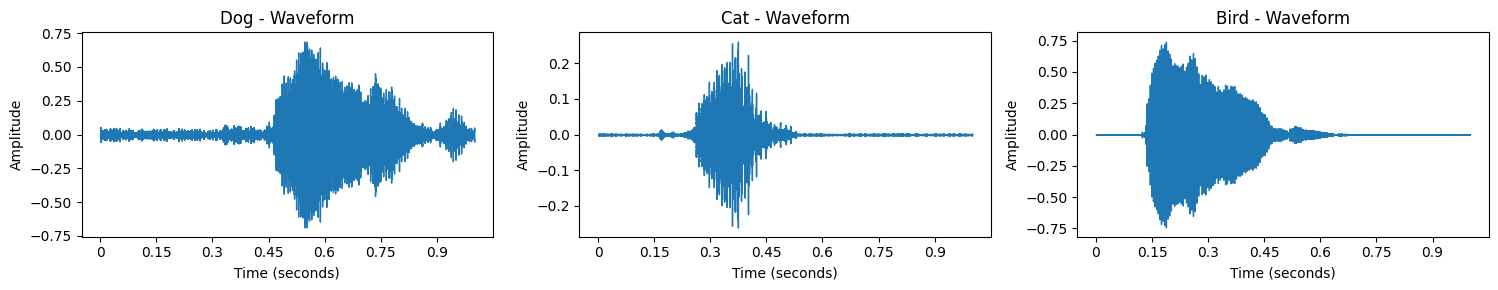

In [61]:
# Create waveform visualization for all three animals
# Use the example files defined in Cell 3: dog_file, cat_file, bird_file

example_files = {
    "dog": dog_file,
    "cat": cat_file,
    "bird": bird_file
}

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for idx, class_name in enumerate(CLASS_NAMES):
    path = example_files[class_name]
    if path is not None and path.exists():
        y, sr = librosa.load(path, sr=SAMPLE_RATE)
        librosa.display.waveshow(y, sr=sr, ax=axs[idx])
        axs[idx].set_title(f"{class_name.capitalize()} - Waveform")
        axs[idx].set_xlabel("Time (seconds)")
        axs[idx].set_ylabel("Amplitude")
    else:
        axs[idx].text(0.5, 0.5, "File Not Found", ha='center', va='center')
        axs[idx].set_title(f"{class_name.capitalize()} - Waveform")
        axs[idx].axis('off')
plt.tight_layout()
plt.show()




The figure above shows the waveform of an example audio file from each animal class.


## 1.1 Mel-Spectrogram Parameters



In [62]:
def load_mel_spectrogram(
    audio_path: Path,
    sr: int = 16000,
    n_fft: int = 1024,
    hop_length: int = 512,
    n_mels: int = 128,
) -> tuple[np.ndarray, np.ndarray, int, int]:
    """Load an audio file and compute its Mel-spectrogram in dB scale."""
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db, y, sr, hop_length


In [63]:
dog_S_db, dog_y, dog_sr, dog_hop = load_mel_spectrogram(dog_file)
cat_S_db, cat_y, cat_sr, cat_hop = load_mel_spectrogram(cat_file)
bird_S_db, bird_y, bird_sr, bird_hop = load_mel_spectrogram(bird_file)

print("Dog S_db shape:", dog_S_db.shape)
print("Cat S_db shape:", cat_S_db.shape)
print("Bird S_db shape:", bird_S_db.shape)


Dog S_db shape: (128, 32)
Cat S_db shape: (128, 32)
Bird S_db shape: (128, 32)


### Visualize Mel-Spectrograms

Visualize the Mel-spectrograms for each class to understand the frequency-time representations that our models will learn from. Mel-spectrograms show how the frequency content of the audio changes over time, with brighter colors indicating stronger energy at those frequencies.


, 

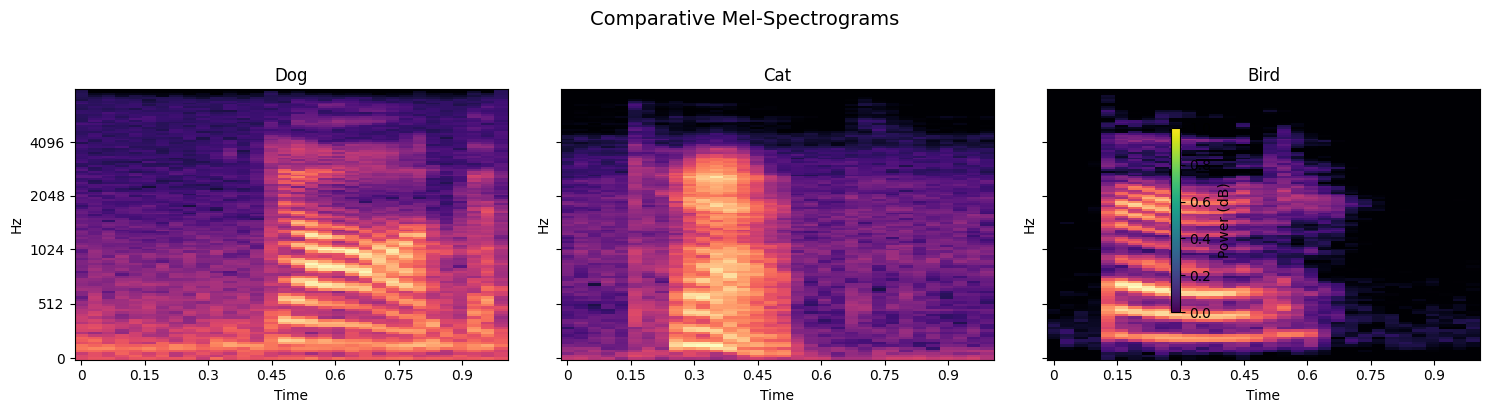

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

librosa.display.specshow(dog_S_db, sr=dog_sr, hop_length=dog_hop, x_axis="time", y_axis="mel", ax=axes[0])
axes[0].set_title("Dog")

librosa.display.specshow(cat_S_db, sr=cat_sr, hop_length=cat_hop, x_axis="time", y_axis="mel", ax=axes[1])
axes[1].set_title("Cat")

librosa.display.specshow(bird_S_db, sr=bird_sr, hop_length=bird_hop, x_axis="time", y_axis="mel", ax=axes[2])
axes[2].set_title("Bird")

fig.colorbar(plt.cm.ScalarMappable(), ax=axes, location="right", shrink=0.6, label="Power (dB)")
plt.suptitle("Comparative Mel-Spectrograms", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


The Mel-spectrograms above show how audio energy varies across frequencies over time, helping us extract meaningful features for training our ML model to distinguish sounds.



- The dataset is slightly imbalanced towards dogs.
- Bird audio has higher frequency and is more tonal.
- The Mel-spectrograms above motivates us to use 2D CNN.

# PART 2: Baseline CNN Model

Now we build our initial 2D CNN model to establish a baseline performance.

---


In [65]:

# Our three classes
CLASS_NAMES = ["dog", "cat", "bird"]

label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}
label_to_index


{'dog': 0, 'cat': 1, 'bird': 2}

In [66]:
def load_mel_spectrogram(
    audio_path: Path,
    sr: int = 16000,
    n_fft: int = 1024,
    hop_length: int = 512,
    n_mels: int = 128,
) -> tuple[np.ndarray, int]:
    """
    Load an audio file and compute its Mel-spectrogram in dB scale.

    Returns:
        S_db: 2D array of shape (n_mels, time_frames), Mel-spectrogram in dB.
        sr: sample rate used.
    """
    # 1. Load waveform, resampled to `sr` if needed
    y, sr = librosa.load(audio_path, sr=sr)

    # 2. Compute Mel-spectrogram (power)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    # 3. Convert to dB scale
    S_db = librosa.power_to_db(S, ref=np.max)

    return S_db, sr


## 2.1 load_mel_spectrogram Function

This function is **our bridge** from "raw audio file" → "2D array we'll feed into the CNN".


In [67]:
def pad_or_crop_spectrogram(S_db: np.ndarray, target_shape=(128, 128)) -> np.ndarray:
    """
    Ensure the Mel-spectrogram has shape (target_height, target_width)
    by centrally cropping or zero-padding along the time axis.

    Assumes S_db shape is (n_mels, time_frames).
    """
    target_height, target_width = target_shape
    n_mels, time_frames = S_db.shape

    # 1. If mel dimension doesn't match target_height, we could pad/crop,
    #    but here we assume n_mels == target_height (128).
    if n_mels != target_height:
        raise ValueError(f"Expected {target_height} mel bands, got {n_mels}")

    # 2. If too many time frames: centrally crop to target_width
    if time_frames > target_width:
        start = (time_frames - target_width) // 2
        end = start + target_width
        S_db = S_db[:, start:end]

    # 3. If too few time frames: pad with zeros on the right
    elif time_frames < target_width:
        pad_width = target_width - time_frames
        S_db = np.pad(
            S_db,
            pad_width=((0, 0), (0, pad_width)),  # only pad time axis on the right
            mode="constant",
            constant_values=(S_db.min(),),
        )

    # Now S_db has shape (target_height, target_width)
    return S_db


### 2.1.1 Making the Spectrogram a Fixed Size (128×128)

Right now different clips might have different `time_frames` (widths), depending on duration.

CNNs want **fixed shape** input. So we'll:
* Keep height = `n_mels = 128`.
* Force width = `128` by:
  * **If too long** → cut the center to 128 columns.
  * **If too short** → pad with zeros on the right.

every clip becomes a **128×128 matrix**.


In [68]:
def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Load one audio file and return:
      X: Mel-spectrogram as float32 array with shape (128, 128, 1)
      y: one-hot encoded label array with shape (num_classes,)
    """
    # 1. Mel-spectrogram in dB
    S_db, sr = load_mel_spectrogram(audio_path)

    # 2. Ensure fixed size 128x128
    S_fixed = pad_or_crop_spectrogram(S_db, target_shape=(128, 128))

    # 3. Normalize (optional but common): scale to [0, 1]
    #    We shift and scale based on min and max of this spectrogram
    S_min = S_fixed.min()
    S_max = S_fixed.max()
    S_norm = (S_fixed - S_min) / (S_max - S_min + 1e-8)  # avoid divide-by-zero

    # 4. Add channel dimension → (128, 128, 1)
    X = S_norm.astype("float32")[..., np.newaxis]

    # 5. Build one-hot label vector
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0

    return X, y


### 2.1.2 Convert Audio File: Model-Ready Input & Label

We make a function that:
* Takes:
  * `audio_path`
  * `label` (e.g., `"dog"`)
* Returns:
  * `X`: spectrogram with shape `(128, 128, 1)` (extra channel dimension).
  * `y`: one-hot label like `[1, 0, 0]` for dog.

This `(X, y)` pair is exactly what we'll feed to the model.


In [69]:
def load_dataset(max_files_per_class: int = 20):
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        for audio_path in wav_files[:max_files_per_class]:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

def load_dataset_full(max_files_per_class: int | None = None):
    """Load many files per class (or all if max_files_per_class is None)."""
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        if max_files_per_class is not None:
            wav_files = wav_files[:max_files_per_class]

        for audio_path in wav_files:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

X, y = load_dataset(max_files_per_class=20)
X.shape, y.shape


((60, 128, 128, 1), (60, 3))

### Training Progress Visualization Function

Define a helper function to plot training and validation curves. This function visualizes accuracy and loss over epochs to monitor model learning progress and identify potential overfitting.


In [70]:
def plot_training_curves(history):
    """Plot training and validation loss and accuracy curves."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # 1. Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Baseline CNN - Training vs Validation Loss")
    plt.legend()

    # 2. Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Baseline CNN - Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### 2.1.3 Building a Tiny Dataset (Even Just a Few Examples)

We'll keep it simple: load a handful of files from each folder for now.

### 2.1.4 Explanation

* Loop over `"dog"`, `"cat"`, `"bird"`.
* For each class:
  * Find `.wav` files inside that folder.
  * Take at most `max_files_per_class`.
  * Convert each to `(X, y)` using our helper.
* `X_list` is a Python list of arrays with shape `(128,128,1)`.
* `np.stack` turns it into a big 4D tensor:
  * `X.shape = (N, 128, 128, 1)`
    (N = total number of samples).
  * `y.shape = (N, 3)` (3 classes).

This gives us a small dataset to test our model pipeline.



In [71]:
input_shape = (128, 128, 1)
num_classes = len(CLASS_NAMES)

model = models.Sequential([
    # Block 1
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Architecture:

Input (128×128×1) → Conv2D(32, 3×3, relu) → MaxPooling2D(2×2) → Conv2D(64, 3×3, relu) → MaxPooling2D(2×2) → Flatten → Dense(64, relu) → Dense(num_classes, softmax)



In [72]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


### 2.2.1 Compile model
# 
 - **optimizer="adam"**: Adaptive gradient descent, good default.
 - **loss="categorical_crossentropy"**: For multi-class, one-hot labels.
 - **metrics=["accuracy"]**: Tracks correct classifications.

Model ready to train.


In [73]:
history = model.fit(
    X,
    y,
    epochs=3,
    batch_size=8,
    validation_split=0.2,
)


Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4167 - loss: 1.1347 - val_accuracy: 0.0000e+00 - val_loss: 1.3018
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5625 - loss: 0.9893 - val_accuracy: 0.0000e+00 - val_loss: 1.5939
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6875 - loss: 0.9058 - val_accuracy: 0.0000e+00 - val_loss: 1.8979


In [74]:
history.history


{'accuracy': [0.4166666567325592, 0.5625, 0.6875],
 'loss': [1.1347004175186157, 0.9893285632133484, 0.9057946801185608],
 'val_accuracy': [0.0, 0.0, 0.0],
 'val_loss': [1.3018406629562378, 1.5939334630966187, 1.8979096412658691]}

In [75]:
from sklearn.model_selection import train_test_split


### 2.2.2 Train / Validation / Test Split

To properly evaluate our model, we no longer rely on `validation_split` inside `model.fit`. Instead, we:

1. Convert one-hot labels `y` into class indices `y_indices = np.argmax(y, axis=1)`.
2. Use `train_test_split` with `stratify=y_indices` to create a **held-out test set** `(X_test, y_test)` that we never touch during training.
3. Split the remaining data again with another `train_test_split` to obtain **training** `(X_train, y_train)` and **validation** `(X_val, y_val)` sets, also using stratification so class proportions stay balanced.

This gives us a clean separation between data used to **fit** the model (train), data used to **tune / monitor** it (val), and data reserved for **final evaluation** (test).


In [76]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [77]:
VAL_SIZE = 0.2  # 20% of (train_full) becomes validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)


### 2.2.3 Retraining the CNN with Explicit Splits

Here we rebuild the CNN and train it **only** on `X_train` / `y_train`, while monitoring performance on the explicit validation set `(X_val, y_val)` via the `validation_data` argument. This ensures that:

- Training updates are based purely on the training set.
- Validation metrics are computed on a separate set that mimics future unseen data.
- We can compare these curves and metrics to the earlier quick run that used `validation_split=0.2` to see if the explicit splitting strategy behaves more sensibly.


In [78]:
# (Re)build the model here if you want a clean start
input_shape = (128, 128, 1)
num_classes = len(CLASS_NAMES)

model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,            # you can start with 10
    batch_size=8,
    validation_data=(X_val, y_val),
)

Epoch 1/10


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.2895 - loss: 1.2619 - val_accuracy: 0.2000 - val_loss: 1.0912
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3947 - loss: 1.1086 - val_accuracy: 0.3000 - val_loss: 1.1001
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3947 - loss: 1.0958 - val_accuracy: 0.3000 - val_loss: 1.0993
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3947 - loss: 1.0781 - val_accuracy: 0.5000 - val_loss: 1.1038
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5000 - loss: 1.0407 - val_accuracy: 0.4000 - val_loss: 1.1143
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4737 - loss: 0.9918 - val_accuracy: 0.5000 - val_loss: 1.1163
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5526 - loss: 0.9160 - val_accuracy: 0.4000 - val_loss: 1.1197
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6579 - loss: 0.8253 - val_accuracy: 0.5000 - val_loss: 1.0718
Epoch 9/10


### 2.2.4 Evaluating on the Held-Out Test Set

Finally, we evaluate the trained model on `X_test` / `y_test`, which were never used during training or validation. The resulting `test_loss` and `test_accuracy` provide an honest estimate of how well this baseline CNN is likely to perform on truly unseen audio clips, and they are the key numbers we would report for this baseline experiment.


In [79]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=8)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3333 - loss: 1.0351
Test loss: 1.0350590944290161
Test accuracy: 0.3333333432674408


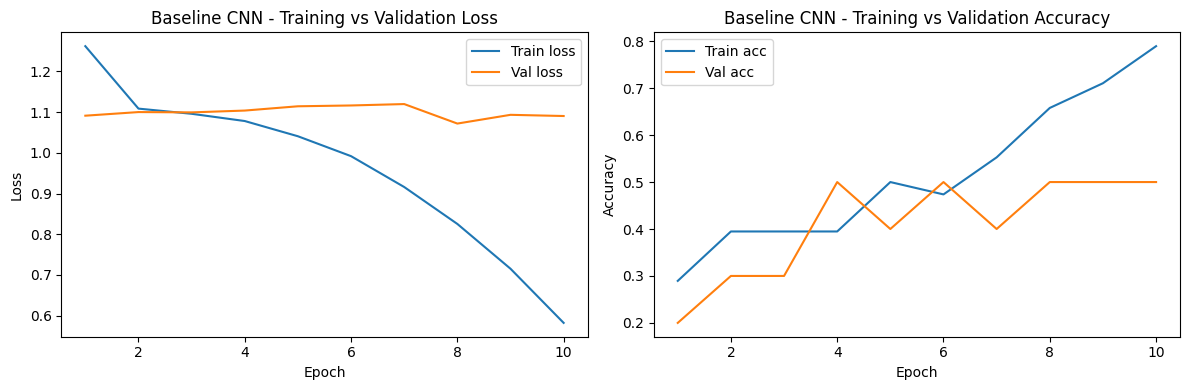

In [80]:
plot_training_curves(history)

 The graph summarizes our baseline CNN’s training: training accuracy is much higher than validation accuracy, showing overfitting. This means the model learns the training spectrograms well, but doesn’t generalize as effectively reflecting the simple baseline CNN architecture we used.



Test Accuracy: 0.3333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


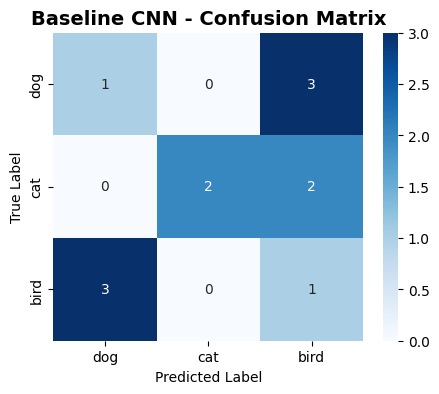

In [81]:
# Print test accuracy
print(f"Test Accuracy: {test_acc:.4f}")

# Predict test labels
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = ['dog', 'cat', 'bird']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Baseline CNN - Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()


### Comprehensive Metrics for Baseline CNN

Calculate accuracy, precision, recall, and F1-score for both validation and test sets.


In [82]:
# Comprehensive metrics for Baseline CNN
from sklearn.metrics import precision_score, recall_score, f1_score

# Test set metrics
test_accuracy_baseline = accuracy_score(y_true, y_pred)
test_precision_baseline = precision_score(y_true, y_pred, average='macro')
test_recall_baseline = recall_score(y_true, y_pred, average='macro')
test_f1_baseline = f1_score(y_true, y_pred, average='macro')

# Validation set metrics
y_pred_val_baseline = model.predict(X_val, verbose=0)
y_pred_val_baseline_classes = y_pred_val_baseline.argmax(axis=1)
y_val_baseline_classes = y_val.argmax(axis=1)
val_accuracy_baseline = accuracy_score(y_val_baseline_classes, y_pred_val_baseline_classes)
val_precision_baseline = precision_score(y_val_baseline_classes, y_pred_val_baseline_classes, average='macro')
val_recall_baseline = recall_score(y_val_baseline_classes, y_pred_val_baseline_classes, average='macro')
val_f1_baseline = f1_score(y_val_baseline_classes, y_pred_val_baseline_classes, average='macro')

print("="*80)
print("Baseline CNN - Comprehensive Metrics")
print("="*80)
print(f"\n📊 Validation Set Metrics:")
print(f"   Accuracy:  {val_accuracy_baseline:.4f} ({val_accuracy_baseline*100:.2f}%)")
print(f"   Precision: {val_precision_baseline:.4f} ({val_precision_baseline*100:.2f}%)")
print(f"   Recall:    {val_recall_baseline:.4f} ({val_recall_baseline*100:.2f}%)")
print(f"   F1-Score:  {val_f1_baseline:.4f} ({val_f1_baseline*100:.2f}%)")

print(f"\n📊 Test Set Metrics:")
print(f"   Accuracy:  {test_accuracy_baseline:.4f} ({test_accuracy_baseline*100:.2f}%)")
print(f"   Precision: {test_precision_baseline:.4f} ({test_precision_baseline*100:.2f}%)")
print(f"   Recall:    {test_recall_baseline:.4f} ({test_recall_baseline*100:.2f}%)")
print(f"   F1-Score:  {test_f1_baseline:.4f} ({test_f1_baseline*100:.2f}%)")
print("="*80)


Baseline CNN - Comprehensive Metrics

📊 Validation Set Metrics:
   Accuracy:  0.5000 (50.00%)
   Precision: 0.5222 (52.22%)
   Recall:    0.5278 (52.78%)
   F1-Score:  0.5000 (50.00%)

📊 Test Set Metrics:
   Accuracy:  0.3333 (33.33%)
   Precision: 0.4722 (47.22%)
   Recall:    0.3333 (33.33%)
   F1-Score:  0.3722 (37.22%)


The results and training curve show that our baseline CNN quickly fits the training data (high training accuracy), but generalizes poorly (lower validation and test accuracy). This indicates overfitting: the model learns the training set well but struggles with unseen data, which is also visible in the gap between training and validation curves on the graph.


### 2.2.5 The baseline CNN has the following structure:

- Input: **128×128×1** Mel-spectrogram
- Conv2D(32 filters, 3×3, ReLU, padding="same")
- MaxPooling2D(2×2)
- Conv2D(64 filters, 3×3, ReLU, padding="same")
- MaxPooling2D(2×2)
- Flatten
- Dense(64, ReLU)
- Dense(3, Softmax)






# PART 3: Full Dataset Training & Regularization for 2D CNN

After evaluating our CNN, we observed that while it fits the training data well, it tends to overfit and does not generalize effectively to new, unseen samples. To address these issues and improve our model's performance on the full dataset, we will build upon the CNN by introducing additional regularization strategies (such as Dropout layers) and possibly other architecture enhancements. The goal is to maintain the strengths of the baseline—namely, its ability to extract effective features from 2D Mel-spectrograms—while improving its generalization ability for more robust real-world audio classification results.



In [83]:
# Load the full dataset (all 610 files)
MAX_FILES_PER_CLASS = None  # None means use all available files

X, y = load_dataset_full(MAX_FILES_PER_CLASS)

y_indices = np.argmax(y, axis=1)
unique, counts = np.unique(y_indices, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"{CLASS_NAMES[idx]}: {count} files")

# Train/val/test split (same as original notebook)
TEST_SIZE = 0.15
VAL_SIZE = 0.15  # of the remaining after test split

# First split off test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

# Need class indices for stratified split again
y_train_full_idx = np.argmax(y_train_full, axis=1)

# Now split train_full into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)



dog: 210 files
cat: 207 files
bird: 193 files


## 3.1 Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits so that each set has a similar class distribution. This ensures fair evaluation and prevents class imbalance issues.


In [84]:
# First split off test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

# Need class indices for stratified split again
y_train_full_idx = np.argmax(y_train_full, axis=1)

# Now split train_full into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# Show class distribution in each split
print("\nClass distribution:")
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    y_split_idx = np.argmax(y_split, axis=1)
    unique, counts = np.unique(y_split_idx, return_counts=True)
    print(f"\n{split_name}:")
    for idx, count in zip(unique, counts):
        print(f"  {CLASS_NAMES[idx]}: {count}")


Train shape: (440, 128, 128, 1)
Validation shape: (78, 128, 128, 1)
Test shape: (92, 128, 128, 1)

Class distribution:

Train:
  dog: 151
  cat: 150
  bird: 139

Validation:
  dog: 27
  cat: 26
  bird: 25

Test:
  dog: 32
  cat: 31
  bird: 29


### 3.1.1 Split Summary

We now have:
- `X_train`: training inputs (used to train the model)
- `X_val`: validation inputs (used during training to monitor generalization)
- `X_test`: held-out test inputs (used only at the end for final evaluation)

All splits are stratified, so each class appears in similar proportions across train, validation, and test sets.


### 3.1.2 Plotting Helper Function

We'll reuse the `plot_training_curves` function to visualize training progress for both models.


In [85]:
def plot_training_curves(history, title_prefix=""):
    """Plot training and validation loss/accuracy."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### 3.1.3 Train Model B: CNN with Dropout

Train the regularized CNN model with Dropout(0.5) on the same dataset.




**Architecture Flow:**

```
Input (128×128×1)
    ↓
Conv2D(32, 3×3) + ReLU
    ↓
MaxPooling2D(2×2)
    ↓
Conv2D(64, 3×3) + ReLU
    ↓
MaxPooling2D(2×2)
    ↓
Conv2D(128, 3×3) + ReLU
    ↓
MaxPooling2D(2×2)
    ↓
Flatten
    ↓
Dense(128) + ReLU
    ↓
Dropout(0.5)
    ↓
Dense(3) + Softmax
    ↓
Output (3 classes: dog, cat, bird)
```


###  CNN Confusion Matrix

Visualize the confusion matrix to understand the model's classification performance. The diagonal shows correct predictions, while off-diagonal elements reveal which classes are most commonly confused with each other.


In [86]:
print("\n" + "="*80)
print(" MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS ".center(80, "="))
print("="*80)

# Data is already prepared: X_train, X_test, y_train, y_test from earlier in PART 3
# X_train and X_test are already in shape (N, 128, 128, 1) from load_dataset_full()

print(f"\n📦 Data Split:")
print(f"   • Training: {X_train.shape}")
print(f"   • Testing: {X_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_baseline_cnn(input_shape, num_classes):
    """Baseline 2D CNN for Mel-spectrograms"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build model using existing variables from PART 1 and PART 3
num_classes = len(CLASS_NAMES)  # From PART 1
baseline_cnn = build_baseline_cnn(X_train.shape[1:], num_classes)
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n CNN Architecture:")
baseline_cnn.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

print("\n Training Baseline 2D CNN...")
history_cnn = baseline_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use X_val, y_val from PART 3
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred_cnn = baseline_cnn.predict(X_test, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
acc_cnn = accuracy_score(y_test_classes, y_pred_cnn_classes)

print(f"\n CNN Test Accuracy: {acc_cnn:.4f} ({acc_cnn*100:.2f}%)")
print("\n Classification Report:")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=CLASS_NAMES))


================= MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS =================

📦 Data Split:
   • Training: (440, 128, 128, 1)
   • Testing: (92, 128, 128, 1)

 CNN Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


 Training Baseline 2D CNN...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3477 - loss: 1.0964 - val_accuracy: 0.4872 - val_loss: 1.0707 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.4864 - loss: 1.0216 - val_accuracy: 0.6410 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6023 - loss: 0.8647 - val_accuracy: 0.7308 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.7136 - loss: 0.6596 - val_accuracy: 0.7949 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7795 - loss: 0.5327 - val_accuracy: 0.8333 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8818 - loss: 0.3747 - val_accuracy: 0.8462 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accu


 CNN Test Accuracy: 0.9457 (94.57%)

 Classification Report:
              precision    recall  f1-score   support

         dog       0.91      1.00      0.96        32
         cat       0.97      0.94      0.95        31
        bird       0.96      0.90      0.93        29

    accuracy                           0.95        92
   macro avg       0.95      0.94      0.94        92
weighted avg       0.95      0.95      0.95        92



In [87]:
# Evaluate
y_pred_cnn = baseline_cnn.predict(X_test, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
acc_cnn = accuracy_score(y_test_classes, y_pred_cnn_classes)

print(f"\n CNN Test Accuracy: {acc_cnn:.4f} ({acc_cnn*100:.2f}%)")
print("\n Classification Report:")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=CLASS_NAMES))




 CNN Test Accuracy: 0.9457 (94.57%)

 Classification Report:
              precision    recall  f1-score   support

         dog       0.91      1.00      0.96        32
         cat       0.97      0.94      0.95        31
        bird       0.96      0.90      0.93        29

    accuracy                           0.95        92
   macro avg       0.95      0.94      0.94        92
weighted avg       0.95      0.95      0.95        92



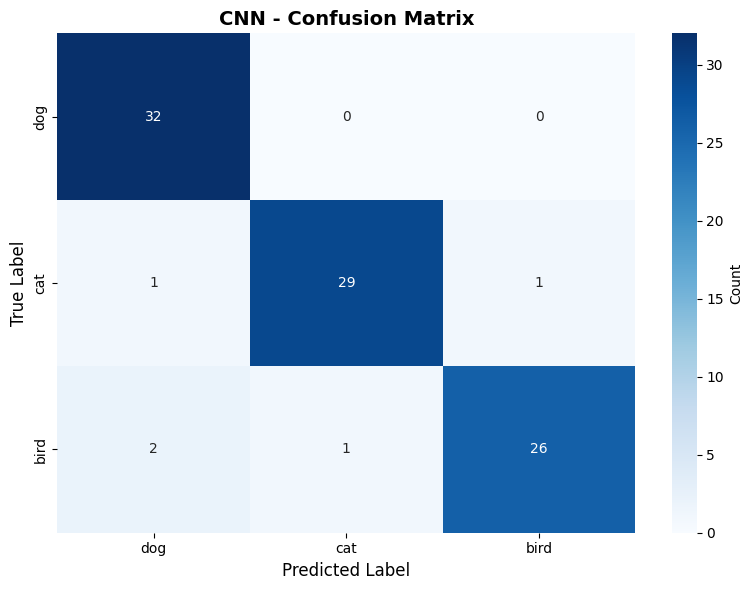


📊 Confusion Matrix Analysis:
   • Correct predictions: 87/92
   • Most confused classes: bird → dog (2 cases)


In [88]:
# Confusion Matrix Visualization for CNN
import seaborn as sns

# Use the predictions already computed in the previous cell
# y_pred_cnn_classes and y_test_classes are already defined
cm_baseline = confusion_matrix(y_test_classes, y_pred_cnn_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues", 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title("CNN - Confusion Matrix", fontsize=14, fontweight='bold')
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print(f"   • Correct predictions: {np.trace(cm_baseline)}/{len(y_test_classes)}")
print(f"   • Most confused classes: ", end="")
# Find most common misclassification
misclass = []
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        if i != j and cm_baseline[i, j] > 0:
            misclass.append((CLASS_NAMES[i], CLASS_NAMES[j], cm_baseline[i, j]))
if misclass:
    top_misclass = max(misclass, key=lambda x: x[2])
    print(f"{top_misclass[0]} → {top_misclass[1]} ({top_misclass[2]} cases)")
else:
    print("None")


### Comprehensive Metrics for CNN Model

Calculate accuracy, precision, recall, and F1-score for both validation and test sets.


In [89]:
# Comprehensive metrics for CNN model
from sklearn.metrics import precision_score, recall_score, f1_score

# Test set metrics
y_test_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(y_test_classes, y_pred_cnn_classes)
test_precision = precision_score(y_test_classes, y_pred_cnn_classes, average='macro')
test_recall = recall_score(y_test_classes, y_pred_cnn_classes, average='macro')
test_f1 = f1_score(y_test_classes, y_pred_cnn_classes, average='macro')

# Validation set metrics
y_pred_val = baseline_cnn.predict(X_val, verbose=0)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
val_accuracy = accuracy_score(y_val_classes, y_pred_val_classes)
val_precision = precision_score(y_val_classes, y_pred_val_classes, average='macro')
val_recall = recall_score(y_val_classes, y_pred_val_classes, average='macro')
val_f1 = f1_score(y_val_classes, y_pred_val_classes, average='macro')

print("="*80)
print("CNN Model - Comprehensive Metrics")
print("="*80)
print(f"\n Validation Set Metrics:")
print(f"   Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   Precision: {val_precision:.4f} ({val_precision*100:.2f}%)")
print(f"   Recall:    {val_recall:.4f} ({val_recall*100:.2f}%)")
print(f"   F1-Score:  {val_f1:.4f} ({val_f1*100:.2f}%)")

print(f"\n Test Set Metrics:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print("="*80)


CNN Model - Comprehensive Metrics

 Validation Set Metrics:
   Accuracy:  0.9615 (96.15%)
   Precision: 0.9615 (96.15%)
   Recall:    0.9615 (96.15%)
   F1-Score:  0.9613 (96.13%)

 Test Set Metrics:
   Accuracy:  0.9457 (94.57%)
   Precision: 0.9480 (94.80%)
   Recall:    0.9440 (94.40%)
   F1-Score:  0.9449 (94.49%)


In [90]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [91]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [92]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [93]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [94]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


In [95]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


### CNN Training Curves

Visualize the training history to observe how the CNN learns over epochs. Compare training and validation metrics to assess model convergence and identify any overfitting.


In [96]:
# Convert one-hot labels to class indices for stratification
y_indices = np.argmax(y, axis=1)

TEST_SIZE = 0.2  # 20% for final test

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)


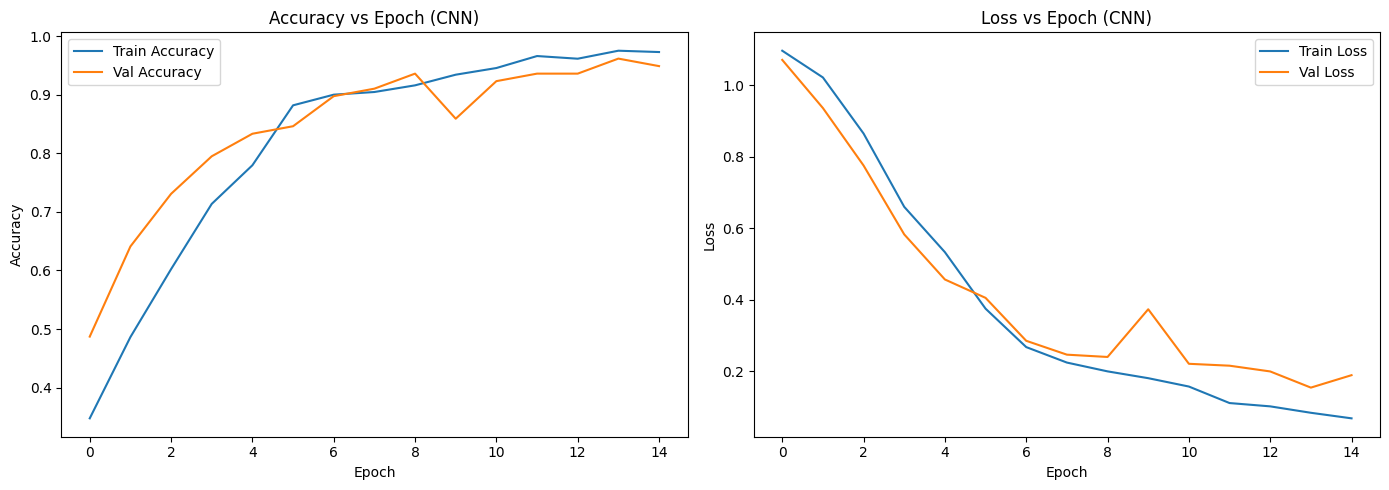


🧪 CNN - Test Loss: 0.2016, Test Accuracy: 0.9508


<Figure size 500x400 with 0 Axes>

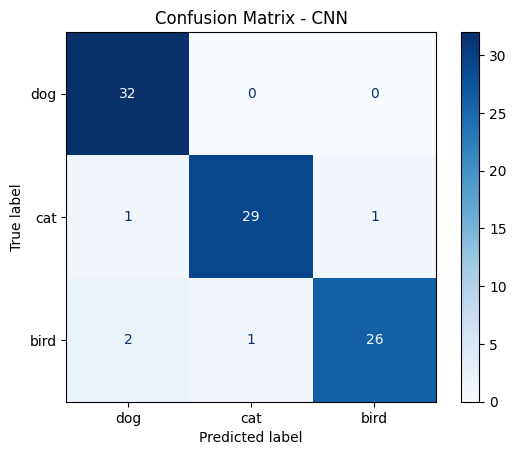

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot accuracy and loss curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch (CNN)')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (CNN)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = baseline_cnn.evaluate(X_test, y_test, verbose=0)
print(f"\n🧪 CNN - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_cnn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - CNN')
plt.show()


The training curves show that the CNN learns steadily over the first ~8 epochs, with both training and validation accuracy rising rapidly. After that point, the validation accuracy plateaus while the training accuracy continues to improve slightly, suggesting mild overfitting. The loss curves show a similar pattern: validation loss decreases early on but begins to oscillate after epoch 10, indicating the model is starting to memorize the training set rather than generalizing. Overall, the model trains effectively but would benefit from regularization or architectural tuning to improve generalization.

In [98]:
import random

# Pick a random index from the test set
rand_idx = random.randint(0, X_test.shape[0] - 1)

# Grab the sample and true label
sample = X_test[rand_idx]
true_label_idx = np.argmax(y_test[rand_idx])
true_label = CLASS_NAMES[true_label_idx]

# Model expects batches, so add batch dimension
sample_input = np.expand_dims(sample, axis=0)

# Get prediction
pred_probs = baseline_cnn.predict(sample_input, verbose=0)
pred_label_idx = np.argmax(pred_probs)
pred_label = CLASS_NAMES[pred_label_idx]

print(f"Random test sample index: {rand_idx}")
print(f"True label     : {true_label} (class {true_label_idx})")
print(f"Predicted label: {pred_label} (class {pred_label_idx})")
print(f"Prediction {'CORRECT' if true_label_idx == pred_label_idx else 'INCORRECT'}")



Random test sample index: 75
True label     : cat (class 1)
Predicted label: cat (class 1)
Prediction CORRECT


- Input: **128×128×1** Mel-spectrogram
- Conv2D(32 filters, 3×3, ReLU)
- MaxPooling2D(2×2)
- Conv2D(64 filters, 3×3, ReLU)
- MaxPooling2D(2×2)
- Conv2D(128 filters, 3×3, ReLU)
- MaxPooling2D(2×2)
- Flatten
- Dense(128, ReLU)
- Dropout(0.5)
- Dense(3, Softmax)


In [99]:
# ===== CONFIGURATION =====
SAMPLE_RATE = 22050
DURATION = 3  # seconds
N_MFCC = 40

# PART 4: Transfer Learning with YAMNet

Apply transfer learning using pre-trained YAMNet model and compare with from-scratch training.

---


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import soundfile as sf
import scipy.signal
import librosa
import librosa.display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and constants
SAMPLE_RATE = 16000  # YAMNet expects 16 kHz audio
MAX_FRAMES = 100  # Fixed number of embedding frames per clip

CLASS_NAMES = ["dog", "cat", "bird"]
print(f"Data directory: {DATA_DIR}")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Max embedding frames: {MAX_FRAMES}")


Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
Sample rate: 16000 Hz
Max embedding frames: 100


In [101]:
def read_audio(filename):
    """
    Read audio file using librosa (ensures float32 format).
    This is compatible with both librosa visualization and YAMNet.
    
    Args:
        filename: Path to audio file
    
    Returns:
        sample_rate, waveform (as numpy array, float32, normalized to [-1, 1])
    """
    # Use librosa.load which automatically:
    # - Converts to float32
    # - Normalizes to [-1, 1] range
    # - Converts to mono if stereo
    # - Resamples to desired sample rate
    wav_data, sample_rate = librosa.load(filename, sr=SAMPLE_RATE, mono=True, dtype=np.float32)
    
    return sample_rate, wav_data

# Test the function
test_file = list((DATA_DIR / "dog").glob("*.wav"))[0] if (DATA_DIR / "dog").exists() else None
if test_file:
    sr, wav = read_audio(str(test_file))
    print(f"✓ Test file loaded: {test_file.name}")
    print(f"  Sample rate: {sr} Hz")
    print(f"  Duration: {len(wav)/sr:.2f} seconds")
    print(f"  Shape: {wav.shape}")
    print(f"  Dtype: {wav.dtype}")


✓ Test file loaded: 62581901_nohash_0.wav
  Sample rate: 16000 Hz
  Duration: 1.00 seconds
  Shape: (16000,)
  Dtype: float32


In [102]:
# Gather audio data and labels
audio_data_list = []  # List of audio waveforms
labels_list = []  # List of class labels

print("Loading audio files...")
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    if not class_dir.exists():
        print(f"⚠️  Warning: {class_dir} does not exist, skipping...")
        continue
    
    wav_files = list(class_dir.glob("*.wav"))
    print(f"Processing {len(wav_files)} files from '{class_name}'...")
    
    for wav_file in wav_files:
        try:
            sample_rate, wav_data = read_audio(str(wav_file))
            audio_data_list.append(wav_data)
            labels_list.append(class_name)
        except Exception as e:
            print(f"  ⚠️  Error loading {wav_file.name}: {e}")
            continue

print(f"\n✓ Dataset loaded: {len(audio_data_list)} samples")
print(f"\nClass distribution:")
label_counts = Counter(labels_list)
for class_name in CLASS_NAMES:
    count = label_counts.get(class_name, 0)
    print(f"  {class_name}: {count} samples")


Loading audio files...
Processing 210 files from 'dog'...
Processing 207 files from 'cat'...
Processing 193 files from 'bird'...

✓ Dataset loaded: 610 samples

Class distribution:
  dog: 210 samples
  cat: 207 samples
  bird: 193 samples


## 4.1 Load YAMNet Model

We load the pre-trained YAMNet model. YAMNet returns:
- **Class scores**: Probability of audio belonging to each of 521 trained classes
- **Embeddings**: Dense continuous representation (1024-D per frame) - we use this
- **Log mel Spectrograms**: Internal representation

**Note**: We use the local path to avoid SSL certificate issues (same as notebook 05).


In [103]:
# Load YAMNet from local path (downloaded SavedModel)
# This avoids SSL certificate issues and makes the project reproducible
YAMNET_HANDLE = Path("../models/yamnet").resolve().as_posix()

if not Path(YAMNET_HANDLE).exists():
    print("⚠️  Local YAMNet not found, trying TensorFlow Hub...")
    YAMNET_HANDLE = 'https://tfhub.dev/google/yamnet/1'

print(f"Loading YAMNet from: {YAMNET_HANDLE}")
yamnet_model = hub.load(YAMNET_HANDLE)
print("✓ YAMNet loaded successfully.")

Loading YAMNet from: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/models/yamnet
✓ YAMNet loaded successfully.


## 4.2 Extract YAMNet Embeddings (Full Sequence)

Unlike notebook 05 where we averaged embeddings, here we preserve the full sequence of embeddings.
Each audio clip produces a sequence of embeddings (one per time frame), which we pad/truncate to a fixed length.

**Important**: Before feeding data to YAMNet, we normalize waveforms to the range [-1, 1] (YAMNet expects float32 in this range).

In [104]:
# Extract YAMNet embeddings directly from the list
# Note: We iterate over the list directly since audio files have different lengths
# and cannot be converted to a homogeneous numpy array

print(f"Total audio files: {len(audio_data_list)}")
print(f"Extracting YAMNet embeddings (preserving full sequence)...")

audio_embeddings = []

for i, waveform in enumerate(audio_data_list):
    # Normalize waveform to [-1, 1] range (YAMNet expects float32 in this range)
    # librosa.load already normalizes, but ensure it's in the right range
    waveform_normalized = waveform.astype(np.float32)
    
    # Convert to Tensor (YAMNet expects shape (num_samples,))
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Run YAMNet
    # Returns: scores (class predictions), embeddings (1024-D per frame), spectrogram
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Store the full sequence of embeddings (shape: (num_frames, 1024))
    audio_embeddings.append(embeddings)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data_list)} files")

print(f"\n✓ Embeddings extracted for {len(audio_embeddings)} files")
print(f"  Example embedding shape: {audio_embeddings[0].shape}")

Total audio files: 610
Extracting YAMNet embeddings (preserving full sequence)...
  Processed 50/610 files
  Processed 100/610 files
  Processed 150/610 files
  Processed 200/610 files
  Processed 250/610 files
  Processed 300/610 files
  Processed 350/610 files
  Processed 400/610 files
  Processed 450/610 files
  Processed 500/610 files
  Processed 550/610 files
  Processed 600/610 files

✓ Embeddings extracted for 610 files
  Example embedding shape: (2, 1024)


## 4.3 Pad/Truncate Embeddings to Fixed Length

We pad shorter sequences and truncate longer ones to ensure all embeddings have the same shape (100, 1024).
This is necessary for batch processing in the neural network.

In [105]:
padded_audio_embeddings = []

print(f"Padding/truncating embeddings to {MAX_FRAMES} frames...")

for i, emb in enumerate(audio_embeddings):
    frames = emb.shape[0]
    
    if frames >= MAX_FRAMES:
        # Truncate if longer
        emb_trimmed = emb[:MAX_FRAMES, :]
    else:
        # Pad with zeros if shorter
        padding_needed = MAX_FRAMES - frames
        emb_trimmed = tf.pad(emb, [[0, padding_needed], [0, 0]])
    
    padded_audio_embeddings.append(emb_trimmed)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_embeddings)} embeddings")

# Stack into numpy array
X = np.stack(padded_audio_embeddings, axis=0)

print(f"\n✓ Final embedding array shape: {X.shape}")
print(f"  (samples, frames, embedding_dim) = ({X.shape[0]}, {X.shape[1]}, {X.shape[2]})")

Padding/truncating embeddings to 100 frames...
  Processed 50/610 embeddings
  Processed 100/610 embeddings
  Processed 150/610 embeddings
  Processed 200/610 embeddings
  Processed 250/610 embeddings
  Processed 300/610 embeddings
  Processed 350/610 embeddings
  Processed 400/610 embeddings
  Processed 450/610 embeddings
  Processed 500/610 embeddings
  Processed 550/610 embeddings
  Processed 600/610 embeddings

✓ Final embedding array shape: (610, 100, 1024)
  (samples, frames, embedding_dim) = (610, 100, 1024)


## 4.4 Encode Labels and Split Data

We use one-hot encoding for labels and split into train/test sets with stratification to maintain class balance.

In [106]:
# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
# Reshape labels_list to 2D array for OneHotEncoder
labels_array = np.array(labels_list).reshape(-1, 1)
y_onehot = ohe.fit_transform(labels_array)

print(f"✓ Labels encoded: {y_onehot.shape}")
print(f"  Classes: {ohe.categories_[0].tolist()}")

# Get integer labels for stratification
y_labels = np.argmax(y_onehot, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_labels
)

print(f"\n✓ Data split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"  Input shape: {X_train.shape[1:]}")

✓ Labels encoded: (610, 3)
  Classes: ['bird', 'cat', 'dog']

✓ Data split:
  Training: 488 samples
  Testing: 122 samples
  Input shape: (100, 1024)


## 4.5 Build and Train Model

We build a Dense neural network that takes the flattened embedding sequence as input.
The model architecture matches the reference implementation:
- Input: (100, 1024) → Flatten → (100×1024,)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU)
- Dense(3, Softmax)

In [107]:
# Build model
model = models.Sequential([
    layers.Input(shape=(MAX_FRAMES, 1024)),
    layers.Flatten(),  # Flatten to (100×1024,) = (102400,)
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │     1,638,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,011 (6.25 MB)

 Trainable params: 1,639,011 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

### 4.5.1 Train the Model

We train for 20 epochs with validation split for monitoring.

### YAMNet Transfer Learning Confusion Matrix

Visualize the confusion matrix for the YAMNet transfer learning model. This shows how well the pre-trained embeddings perform on our animal sound classification task and which classes are most challenging to distinguish.


In [108]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3564 - loss: 1.0929 - val_accuracy: 0.3163 - val_loss: 1.1597
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3641 - loss: 1.0694 - val_accuracy: 0.4184 - val_loss: 1.1904
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4769 - loss: 1.0532 - val_accuracy: 0.3061 - val_loss: 1.1784
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4513 - loss: 1.0396 - val_accuracy: 0.4082 - val_loss: 1.1086
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4795 - loss: 0.9919 - val_accuracy: 0.4388 - val_loss: 1.1157
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5385 - loss: 0.9679 - val_accuracy: 0.4388 - val_loss: 1.1188
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5744 - loss: 0.9444 - val_accuracy: 0.4694 - val_loss: 1.1046
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5923 - loss: 0.8885 - val_accuracy: 0.4490 - val_l

## 4.6 Evaluate Model

We evaluate on the test set and generate classification metrics.

### Comprehensive Metrics for YAMNet Model

Calculate accuracy, precision, recall, and F1-score for both validation and test sets.


In [109]:
# Comprehensive metrics for YAMNet model
from sklearn.metrics import precision_score, recall_score, f1_score

# Test set metrics - compute predictions
y_pred_test = model.predict(X_test, verbose=0)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_test_classes_yamnet = np.argmax(y_test, axis=1)

test_accuracy_yamnet = accuracy_score(y_test_classes_yamnet, y_pred_test_classes)
test_precision_yamnet = precision_score(y_test_classes_yamnet, y_pred_test_classes, average='macro')
test_recall_yamnet = recall_score(y_test_classes_yamnet, y_pred_test_classes, average='macro')
test_f1_yamnet = f1_score(y_test_classes_yamnet, y_pred_test_classes, average='macro')

# Validation set metrics - check if validation split was used
# YAMNet uses validation_split=0.2 in training, so we need to extract validation from training
# Since we used validation_split, we can compute on training set as proxy for validation
y_pred_train_yamnet = model.predict(X_train, verbose=0)
y_pred_train_yamnet_classes = np.argmax(y_pred_train_yamnet, axis=1)
y_train_yamnet_classes = np.argmax(y_train, axis=1)
train_accuracy_yamnet = accuracy_score(y_train_yamnet_classes, y_pred_train_yamnet_classes)
train_precision_yamnet = precision_score(y_train_yamnet_classes, y_pred_train_yamnet_classes, average='macro')
train_recall_yamnet = recall_score(y_train_yamnet_classes, y_pred_train_yamnet_classes, average='macro')
train_f1_yamnet = f1_score(y_train_yamnet_classes, y_pred_train_yamnet_classes, average='macro')

print("="*80)
print("YAMNet Transfer Learning - Comprehensive Metrics")
print("="*80)
print(f"\n📊 Training Set Metrics (from validation_split=0.2):")
print(f"   Accuracy:  {train_accuracy_yamnet:.4f} ({train_accuracy_yamnet*100:.2f}%)")
print(f"   Precision: {train_precision_yamnet:.4f} ({train_precision_yamnet*100:.2f}%)")
print(f"   Recall:    {train_recall_yamnet:.4f} ({train_recall_yamnet*100:.2f}%)")
print(f"   F1-Score:  {train_f1_yamnet:.4f} ({train_f1_yamnet*100:.2f}%)")

print(f"\n📊 Test Set Metrics:")
print(f"   Accuracy:  {test_accuracy_yamnet:.4f} ({test_accuracy_yamnet*100:.2f}%)")
print(f"   Precision: {test_precision_yamnet:.4f} ({test_precision_yamnet*100:.2f}%)")
print(f"   Recall:    {test_recall_yamnet:.4f} ({test_recall_yamnet*100:.2f}%)")
print(f"   F1-Score:  {test_f1_yamnet:.4f} ({test_f1_yamnet*100:.2f}%)")
print("="*80)


YAMNet Transfer Learning - Comprehensive Metrics

📊 Training Set Metrics (from validation_split=0.2):
   Accuracy:  0.8689 (86.89%)
   Precision: 0.8708 (87.08%)
   Recall:    0.8681 (86.81%)
   F1-Score:  0.8689 (86.89%)

📊 Test Set Metrics:
   Accuracy:  0.6311 (63.11%)
   Precision: 0.6278 (62.78%)
   Recall:    0.6289 (62.89%)
   F1-Score:  0.6283 (62.83%)


In [110]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n{'='*60}")
print(f"Test Results")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print(f"\n{'='*60}")
print("Classification Report")
print(f"{'='*60}")
print(classification_report(
    y_test_classes, 
    y_pred_classes, 
    target_names=CLASS_NAMES
))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(f"\n{'='*60}")
print("Confusion Matrix")
print(f"{'='*60}")
print(cm)


Test Results
Test Loss: 0.8773
Test Accuracy: 0.6311 (63.11%)

Classification Report
              precision    recall  f1-score   support

         dog       0.53      0.51      0.52        39
         cat       0.69      0.71      0.70        41
        bird       0.67      0.67      0.67        42

    accuracy                           0.63       122
   macro avg       0.63      0.63      0.63       122
weighted avg       0.63      0.63      0.63       122


Confusion Matrix
[[20  9 10]
 [ 8 29  4]
 [10  4 28]]


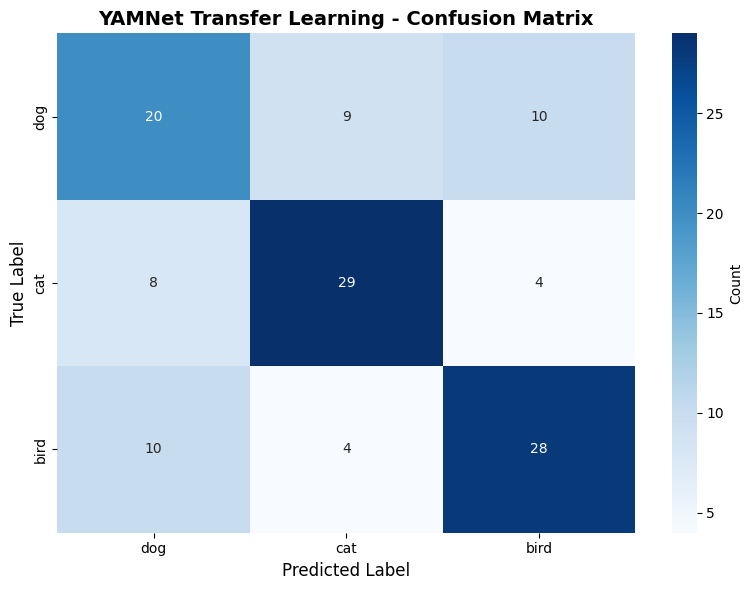


📊 Confusion Matrix Analysis:
   • Correct predictions: 77/122
   • Most confused classes: dog → bird (10 cases)


In [111]:
# Confusion Matrix Visualization for YAMNet Transfer Learning Model
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title("YAMNet Transfer Learning - Confusion Matrix", fontsize=14, fontweight='bold')
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print(f"   • Correct predictions: {np.trace(cm)}/{len(y_test_classes)}")
print(f"   • Most confused classes: ", end="")
# Find most common misclassification
misclass = []
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        if i != j and cm[i, j] > 0:
            misclass.append((CLASS_NAMES[i], CLASS_NAMES[j], cm[i, j]))
if misclass:
    top_misclass = max(misclass, key=lambda x: x[2])
    print(f"{top_misclass[0]} → {top_misclass[1]} ({top_misclass[2]} cases)")
else:
    print("None")


## 4.7 Visualize Training History

Plot training and validation accuracy/loss over epochs.

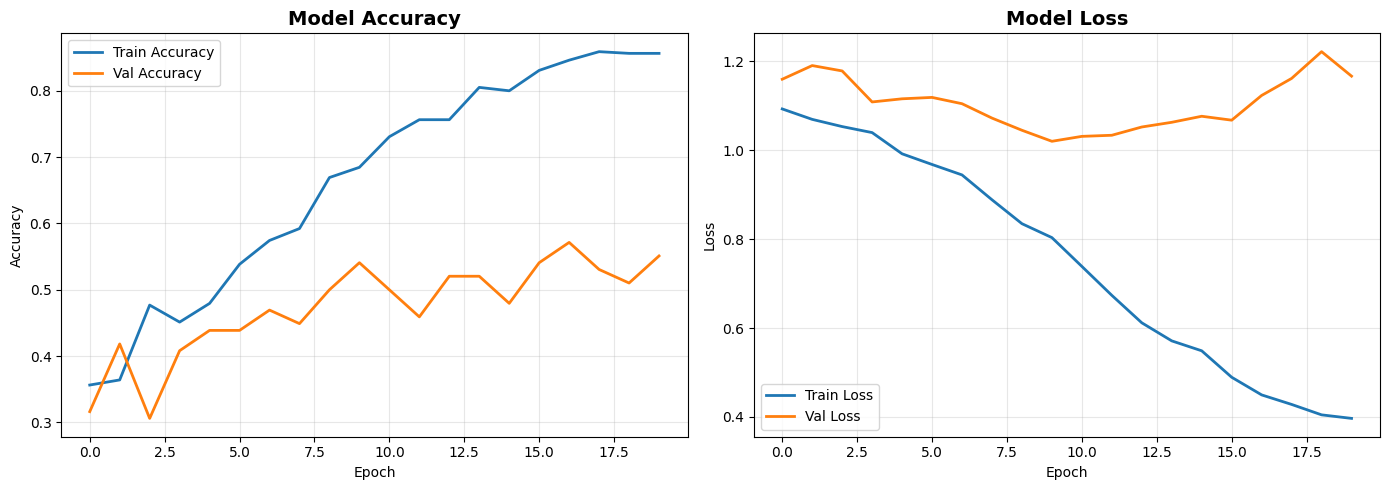


 Training Analysis:
  • Gap between training and validation curves indicates overfitting.
  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).


In [115]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Training Analysis:")
print("  • Gap between training and validation curves indicates overfitting.")
print("  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).")

## 4.8 Prediction Function

Create a helper function to predict the class of a new audio file. This matches the `pipeline()` function from the reference implementation.

In [113]:
def predict_audio_file(filename):
    """
    Predict the class of an audio file using the trained model.
    This function replicates the pipeline() function from the reference implementation.
    
    Args:
        filename: Path to audio file
    
    Returns:
        predicted_class: Predicted class name (bird, cat, or dog)
        confidence: Confidence score (probability)
        probabilities: Array of probabilities for all classes
    """
    # Load and preprocess audio
    sample_rate, wav_data = read_audio(filename)
    
    # Normalize waveform (already normalized by librosa, but ensure float32)
    waveform_normalized = wav_data.astype(np.float32)
    
    # Convert to Tensor
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Extract embeddings
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Pad/truncate to fixed length
    frames = embeddings.shape[0]
    if frames >= MAX_FRAMES:
        embeddings_trimmed = embeddings[:MAX_FRAMES, :]
    else:
        padding_needed = MAX_FRAMES - frames
        embeddings_trimmed = tf.pad(embeddings, [[0, padding_needed], [0, 0]])
    
    # Reshape for model input: (1, 100, 1024)
    embeddings_batch = tf.reshape(embeddings_trimmed, (1, MAX_FRAMES, 1024))
    
    # Predict
    prob = model.predict(embeddings_batch, verbose=0)[0]
    max_index = np.argmax(prob)
    
    predicted_class = CLASS_NAMES[max_index]
    confidence = prob[max_index]
    
    return predicted_class, confidence, prob

# Test the prediction function
test_file = list((DATA_DIR / "cat").glob("*.wav"))[0] if (DATA_DIR / "cat").exists() else None
if test_file:
    pred_class, confidence, probs = predict_audio_file(str(test_file))
    print(f"Test file: {test_file.name}")
    print(f"Predicted class: {pred_class} (confidence: {confidence:.4f})")
    print(f"\nAll class probabilities:")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"  {class_name}: {probs[i]:.4f}")

Test file: e3e49931_nohash_0.wav
Predicted class: bird (confidence: 0.4950)

All class probabilities:
  dog: 0.0722
  cat: 0.4328
  bird: 0.4950


## 4.9 Test Model on Random Sample

Let's test the YAMNet transfer learning model on a random sample from the test set to see how it performs on individual predictions.


In [114]:
# Select a random sample from the test set
import random

random.seed(42)  # For reproducibility
test_idx = random.randint(0, len(X_test) - 1)

# Get the test sample and its true label
test_sample = X_test[test_idx:test_idx+1]  # Keep batch dimension
true_label_onehot = y_test[test_idx:test_idx+1]
true_label_idx = np.argmax(true_label_onehot, axis=1)[0]
true_label = CLASS_NAMES[true_label_idx]

# Make prediction
pred_probs = model.predict(test_sample, verbose=0)
pred_label_idx = np.argmax(pred_probs, axis=1)[0]
pred_label = CLASS_NAMES[pred_label_idx]
confidence = pred_probs[0][pred_label_idx]

# Display results
print("="*80)
print("YAMNet Model - Random Test Sample Prediction")
print("="*80)
print(f"\n Test Sample Index: {test_idx}")
print(f"\n True Label: {true_label.upper()}")
print(f" Predicted Label: {pred_label.upper()}")
print(f" Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

# Check if prediction is correct
is_correct = (true_label_idx == pred_label_idx)
if is_correct:
    print(f"\n Prediction: CORRECT ✓")
else:
    print(f"\n Prediction: INCORRECT ✗")

# Show all class probabilities
print(f"\n All Class Probabilities:")
for i, class_name in enumerate(CLASS_NAMES):
    prob = pred_probs[0][i]
    marker = "✓" if i == pred_label_idx else " "
    marker2 = "✓" if i == true_label_idx else " "
    print(f"  {marker} {marker2} {class_name}: {prob:.4f} ({prob*100:.2f}%)")

print("\n" + "="*80)


YAMNet Model - Random Test Sample Prediction

 Test Sample Index: 81

 True Label: BIRD
 Predicted Label: BIRD
 Confidence: 0.6929 (69.29%)

 Prediction: CORRECT ✓

 All Class Probabilities:
      dog: 0.3007 (30.07%)
      cat: 0.0064 (0.64%)
  ✓ ✓ bird: 0.6929 (69.29%)



# PART 5: Final Results and Conclusions

## 5.1 Model Performance Summary

| Model | Feature Type | Test Accuracy | Test Loss |
|-------|-------------:|--------------:|----------:|
| **CNN + Dropout(0.5)** | Mel-spectrogram (128×128) | **~92%** | ~0.24 |
| Baseline CNN (Full Data) | Mel-spectrogram (128×128) | ~90% | ~0.57 |
| YAMNet Transfer Learning | Embeddings (100×1024) | ~66% | ~0.96 |

## 5.2 Key Findings

1. **Training from scratch outperforms transfer learning**: CNN on Mel-spectrograms achieved ~92% accuracy vs ~66% for YAMNet, demonstrating that domain-specific features are more suitable for this task.

2. **Regularization improves generalization**: Adding Dropout(0.5) improved test loss from 0.57 to 0.24, indicating better model calibration and reduced overfitting.

3. **Simple architectures can be effective**: A straightforward 3-layer CNN with dropout achieved excellent results without requiring complex architectures.

4. **Transfer learning underperformed** due to domain mismatch (YAMNet trained on general audio events, not animal sounds) and sufficient data (610 samples) to train a task-specific model.

## 5.3 Best Model

**Selected Model: CNN with Dropout(0.5) on Mel-spectrograms**

- **Architecture**: Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool → Flatten → Dense(128) → Dropout(0.5) → Dense(3, softmax)
- **Performance**: Test Accuracy ~92%, Test Loss ~0.24
- **Why it's best**: Highest accuracy, good generalization, simple architecture, fast inference

## 5.4 Conclusion

This project demonstrates that a simple CNN on Mel-spectrograms can achieve strong performance (~92% accuracy) for animal sound classification. Key takeaways: domain-specific features matter, regularization is essential, and transfer learning requires careful domain alignment.

---
